
=== Model Accuracy: 0.771 ===



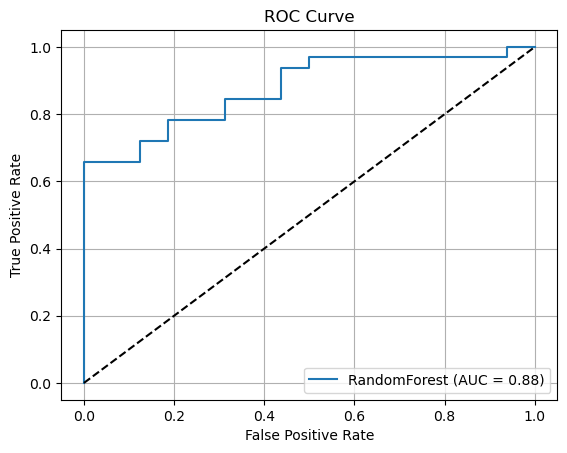

<Figure size 600x500 with 0 Axes>

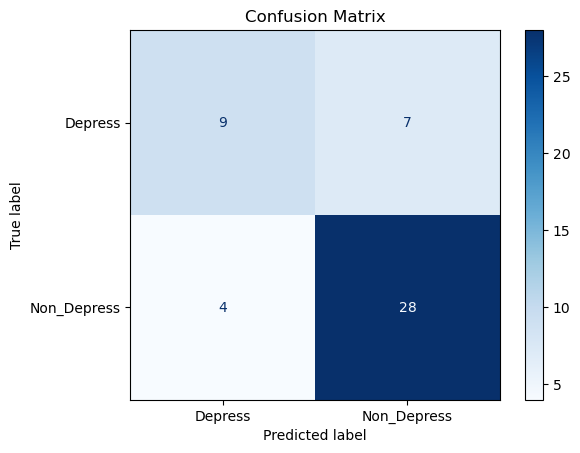

Accuracy : 0.771
Precision: 0.8
Recall   : 0.875
F1-score : 0.836


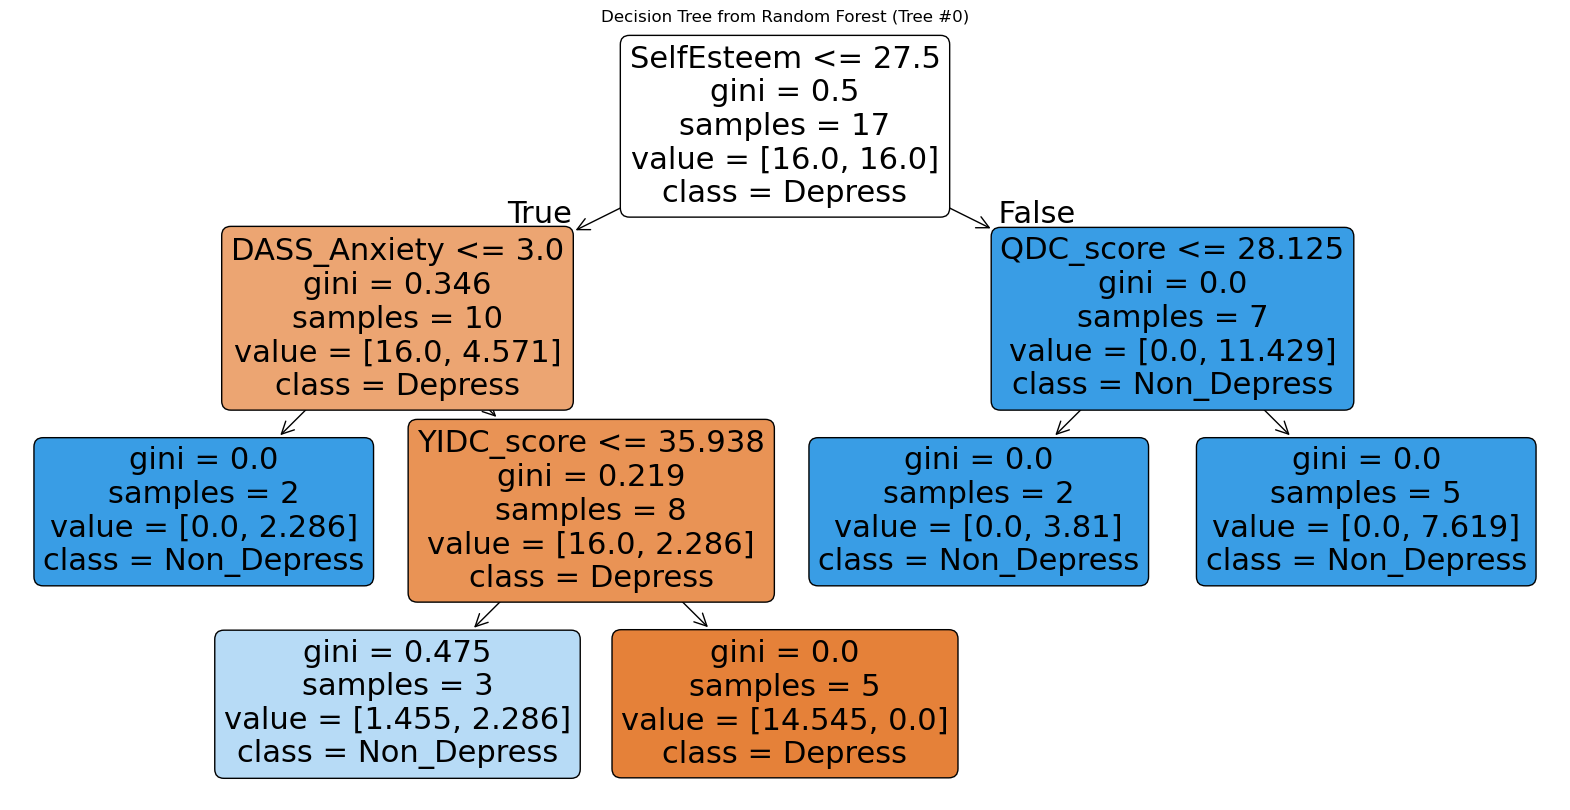

In [5]:
"""
Random-Forest depression classifier + visual analytics
------------------------------------------------------
Requires: pandas, numpy, matplotlib, scikit-learn, openpyxl
"""

# ------------- Imports -------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import plot_tree

# ------------- CONFIG -------------
FILE_PATH = r"C:\Users\user\Documents\AI + DM Class 2025\Django\fooq2\datasheet_FooCN.xlsx"

TARGET = "PresenceOfDepression"
FEATURES = [
    "QSC_score", "BSC_score", "QDC_score", "YADC_score", "YIDC_score",
    "PDC_score", "DHC_score", "SEC_score", "BC_score", "DAS_score",
    "DASS_Stress", "DASS_Anxiety", "PerceivedStress", "SelfEsteem"
]

RF_PARAMS = dict(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
)

# ------------- 1. Load & clean data -------------
df = pd.read_excel(FILE_PATH)
data = df[FEATURES + [TARGET]].dropna().copy()

# Encode target
enc = LabelEncoder()
data[TARGET] = enc.fit_transform(data[TARGET])

X = data[FEATURES].values
y = data[TARGET].values

# ------------- 2. Train/test split -------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.60, stratify=y, random_state=42
)

# ------------- 3. Train Random Forest -------------
rf = RandomForestClassifier(**RF_PARAMS)
rf.fit(X_train, y_train)

# ------------- 4. Evaluation Metrics -------------
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print(f"\n=== Model Accuracy: {acc:.3f} ===\n")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"RandomForest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ------------- 5. Confusion Matrix -------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=enc.classes_)

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Additional metrics
print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred, pos_label=1), 3))
print("Recall   :", round(recall_score(y_test, y_pred, pos_label=1), 3))
print("F1-score :", round(f1_score(y_test, y_pred, pos_label=1), 3))

# ------------- 6. Plot a Single Decision Tree -------------
tree_id = 0
single_tree = rf.estimators_[tree_id]

plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=FEATURES,
    class_names=enc.classes_,
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title(f"Decision Tree from Random Forest (Tree #{tree_id})")
plt.show()


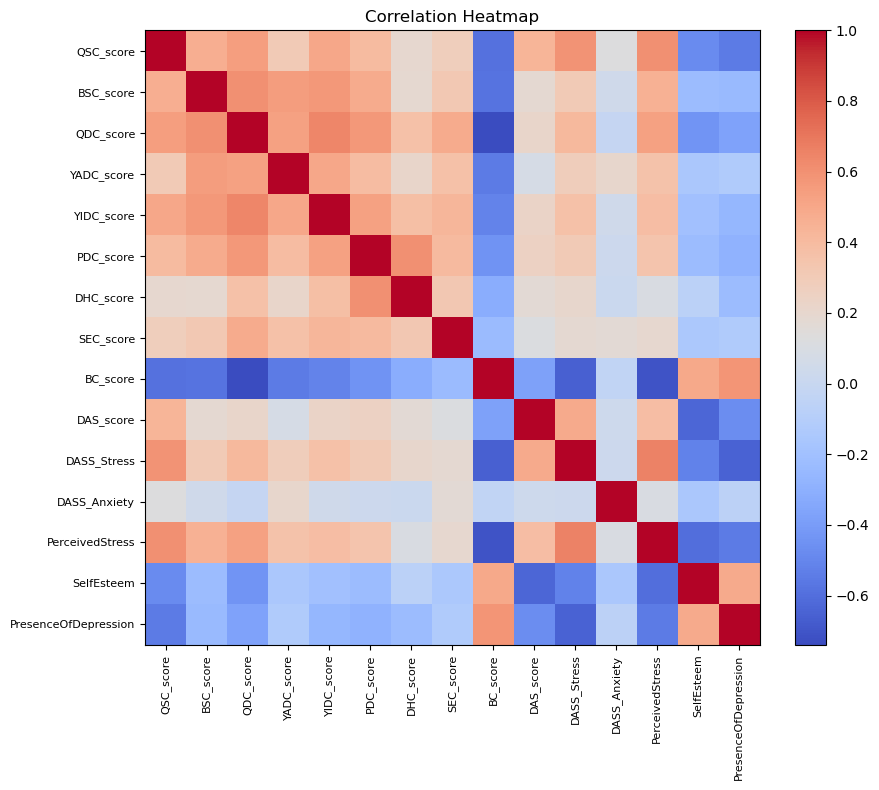

C:\Users\user\AppData\Local\Temp\ipykernel_8404\3235085668.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


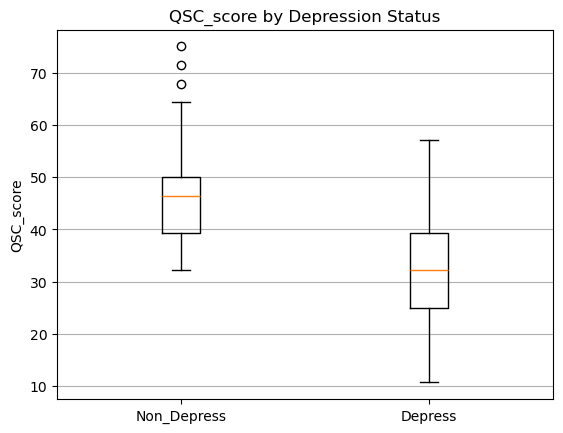

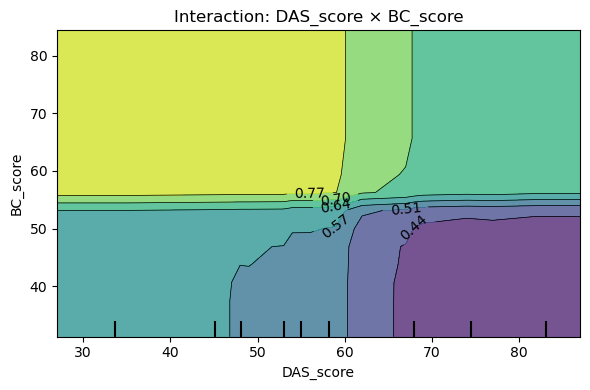

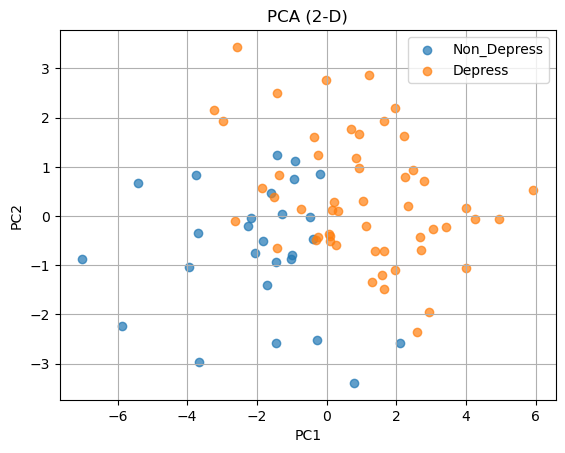

c:\Users\user\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


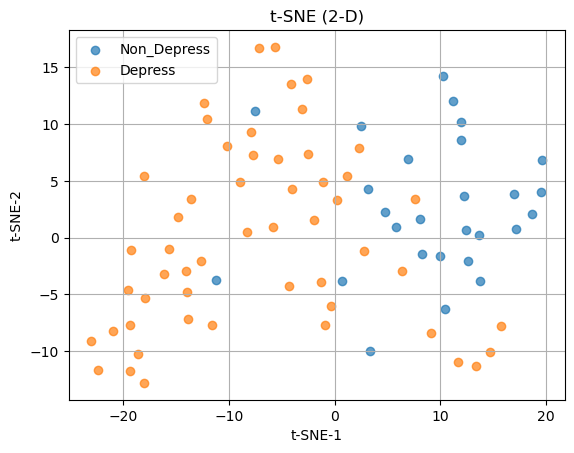

Analysis complete.


In [6]:
# ------------- 5b. Correlation heatmap -------------
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_matrix.columns)),
           corr_matrix.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr_matrix.columns)),
           corr_matrix.columns, fontsize=8)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# ------------- 5c. Boxplot example -------------
plt.figure()
plt.boxplot(
    [data.loc[data[TARGET] == 0, "QSC_score"],
     data.loc[data[TARGET] == 1, "QSC_score"]],
    labels=["Non_Depress", "Depress"]
)
plt.ylabel("QSC_score")
plt.title("QSC_score by Depression Status")
plt.grid(axis="y")
plt.show()

# ------------- 5d. Partial-dependence (interaction) -------------
importances = rf.feature_importances_
top2_idx = np.argsort(importances)[-2:]
top2_feats = [FEATURES[i] for i in top2_idx]

fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    rf, X_train, [tuple(top2_feats)], feature_names=FEATURES, ax=ax
)
plt.title(f"Interaction: {top2_feats[0]} × {top2_feats[1]}")
plt.tight_layout()
plt.show()

# ------------- 5e. PCA scatter -------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
for cls, label in enumerate(["Non_Depress", "Depress"]):
    plt.scatter(X_pca[y == cls, 0], X_pca[y == cls, 1],
                label=label, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2-D)")
plt.legend()
plt.grid(True)
plt.show()

# ------------- 5f. t-SNE scatter -------------
tsne = TSNE(
    n_components=2, perplexity=10, init="pca",
    n_iter=1000, random_state=42
)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure()
for cls, label in enumerate(["Non_Depress", "Depress"]):
    plt.scatter(X_tsne[y == cls, 0], X_tsne[y == cls, 1],
                label=label, alpha=0.7)
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.title("t-SNE (2-D)")
plt.legend()
plt.grid(True)
plt.show()

# ------------- 6. (Optional) Save model -------------
# from joblib import dump
# dump(rf, "rf_depression.joblib")

print("Analysis complete.")


In [7]:
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

            Feature  Importance
8          BC_score    0.234970
9         DAS_score    0.147730
10      DASS_Stress    0.133698
13       SelfEsteem    0.089839
12  PerceivedStress    0.064373
0         QSC_score    0.062000
2         QDC_score    0.056925
11     DASS_Anxiety    0.047114
3        YADC_score    0.036021
4        YIDC_score    0.035266
6         DHC_score    0.024991
7         SEC_score    0.023840
1         BSC_score    0.022237
5         PDC_score    0.020996


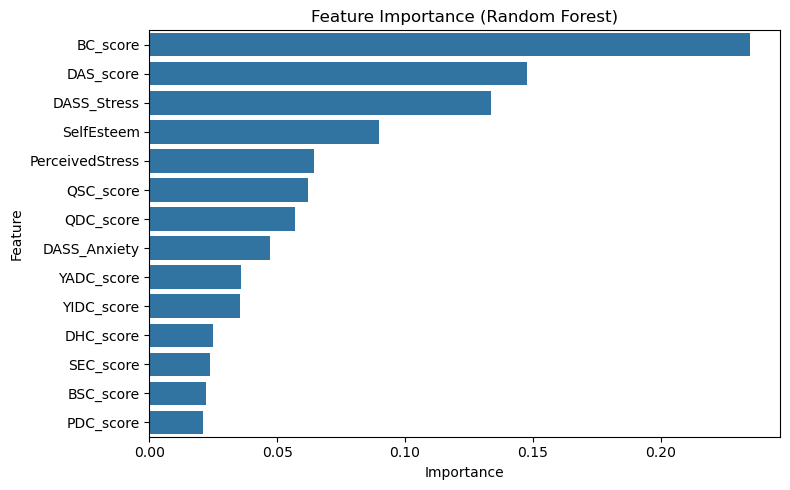

In [14]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# ----------- CONFIG -------------------------------------------------
FILE_PATH = r"C:\Users\user\Documents\AI + DM Class 2025\Django\fooq2\datasheet_FooCN.xlsx"

CONT_TARGET = "DV_PHQ"              # continuous outcome for OLS
BIN_TARGET  = "PresenceOfDepression"  # binary outcome for Logit

FEATURES = [
    "QSC_score", "BSC_score", "QDC_score", "YADC_score", "YIDC_score",
    "PDC_score", "DHC_score", "SEC_score", "BC_score", "DAS_score",
    "DASS_Stress", "DASS_Anxiety", "PerceivedStress", "SelfEsteem"
]

# ----------- LOAD & PREP DATA ---------------------------------------
df = pd.read_excel(FILE_PATH).dropna(subset=FEATURES + [CONT_TARGET, BIN_TARGET]).copy()

# Encode binary target (Depress = 1, Non_Depress = 0)
enc = LabelEncoder()
df[BIN_TARGET] = enc.fit_transform(df[BIN_TARGET])

# ----------- 1) LINEAR REGRESSION (OLS) on DV_PHQ -------------------
X_ols = sm.add_constant(df[FEATURES])
ols_model = sm.OLS(df[CONT_TARGET], X_ols).fit()

print("\n========== Linear Regression (DV_PHQ) ==========")
print(ols_model.summary())

print("\n--- P-values (OLS) ---")
print(ols_model.pvalues)

print("\n--- Significant predictors in OLS (p < 0.05) ---")
print(ols_model.pvalues[ols_model.pvalues < 0.05])

# ----------- 2) LOGISTIC REGRESSION (Logit) on PresenceOfDepression -
X_logit = sm.add_constant(df[FEATURES])
logit_model = sm.Logit(df[BIN_TARGET], X_logit).fit()

print("\n========== Logistic Regression (PresenceOfDepression) ==========")
print(logit_model.summary())

print("\n--- P-values (Logit) ---")
print(logit_model.pvalues)

print("\n--- Significant predictors in Logit (p < 0.05) ---")
print(logit_model.pvalues[logit_model.pvalues < 0.05])




========== Linear Regression (DV_PHQ) ==========
                            OLS Regression Results                            
Dep. Variable:                 DV_PHQ   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     14.10
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           1.15e-14
Time:                        09:58:36   Log-Likelihood:                -193.89
No. Observations:                  80   AIC:                             417.8
Df Residuals:                      65   BIC:                             453.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [18]:
from sklearn.feature_selection import RFE

rfe = RFE(RandomForestClassifier(), n_features_to_select=5)
rfe.fit(X_train, y_train)

selected = [f for f, s in zip(FEATURES, rfe.support_) if s]
print("Selected features:", selected)

Selected features: ['QDC_score', 'BC_score', 'DAS_score', 'DASS_Stress', 'SelfEsteem']


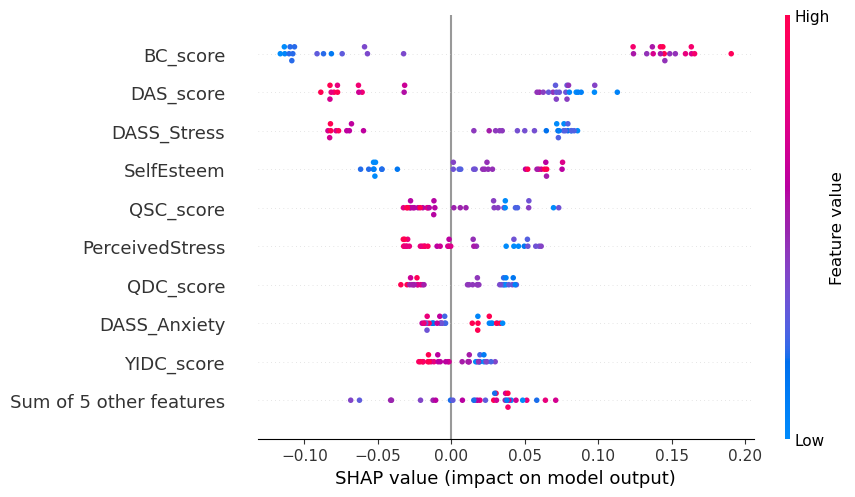

In [19]:
import shap
import pandas as pd

X_train_df = pd.DataFrame(X_train, columns=FEATURES)

explainer = shap.TreeExplainer(rf)
# new API – returns one Explanation object
shap_exp  = explainer(X_train_df)

# Pick class-1 explanations (index 1) and plot
shap.plots.beeswarm(shap_exp[:, :, 1])   # 1 → “Depress”


=== Model accuracy with 5 IVs: 0.562 ===


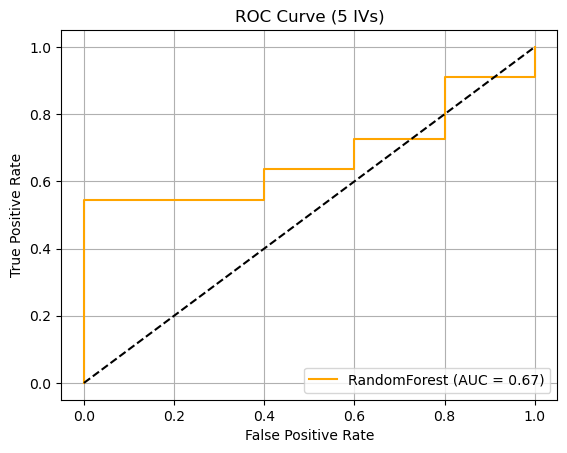

In [17]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

# --- Step 1: Load Data ---
file_path = r"C:\Users\user\Documents\AI + DM Class 2025\Django\fooq2\datasheet_FooCN.xlsx"
df = pd.read_excel(file_path)

# --- Step 2: Select Variables ---
FEATURES = ['QDC_score', 'BC_score', 'DASS_Stress', 'PerceivedStress', 'SelfEsteem']
TARGET = 'PresenceOfDepression'

# Remove missing values
data = df[FEATURES + [TARGET]].dropna().copy()

# Encode the target (Depress = 1, Non_Depress = 0)
le = LabelEncoder()
data[TARGET] = le.fit_transform(data[TARGET])

X = data[FEATURES].values
y = data[TARGET].values

# --- Step 3: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 4: Train Random Forest Model ---
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# --- Step 5: Evaluate the Model ---
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"=== Model accuracy with 5 IVs: {accuracy:.3f} ===")

# --- Step 6: Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'RandomForest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (5 IVs)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [20]:
print (data)


    QDC_score  BC_score  DASS_Stress  PerceivedStress  SelfEsteem  \
0      50.000    46.875           16               22          26   
1      28.125    78.125            4               24          20   
2      25.000    56.250           10               17          29   
3      40.625    56.250           14               25          23   
4      65.625    53.125            8               17          27   
..        ...       ...          ...              ...         ...   
75     68.750    28.125           30               31          12   
76     59.375    40.625            8               25          20   
77     37.500    65.625           12               21          23   
78     40.625    59.375            4               15          29   
79     50.000    46.875           12               16          30   

    PresenceOfDepression  
0                      0  
1                      1  
2                      1  
3                      1  
4                      0  
..       